In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


In [2]:
class MLFF(object):
    def __init__(self,d1 = 27,weight_initializer = 'random'):
        """
        a 3-layer MLFF network:  d input,  2*d+1 neuron in one hidden layer, 1 output neuron
        """
        d2 = d1 * 2 + 1
        self.d1 = d1
        self.d2 = d2
        # w1: the weights between input layer and hidden layer
        # with shape of d2 rows x d1 columns.
        # Each row of w1 represents the weigths associated with a neuron in hidden layer
        # After adding bias, there are  d2*(d1+1) weights connecting input layer to hidden layer

        if weight_initializer == 'random':
            nums = np.round(np.random.random((d1+1) * d2)-np.random.random((d1+1) * d2), 4)*10
        else:
            nums = [0.0] * ((d1 + 1) * d2)
        self.w1 = np.array(nums).reshape([d2,(d1+1)])

        # w2: the weights between hidden layer and output layer
        # there are d2 number of weight , plus one bias. Hence there are d2+1 weights
        if weight_initializer == 'random':
            nums = np.round(np.random.random(d2+1) - np.random.random(d2+1),3)*10
        else:
            nums = [0.0]*(d2+1)
        self.w2 = np.array(nums)

        self.activation_hidden = 'logistic'
        self.activation_out = 'logistic'
        # self.activate_h1 = lambda x:np.ones(self.d1)/(np.ones(self.d1)+ np.exp(-x))




def load_data():
    fp = open('db4_Diff1f_100_128w_AEP2_gp2_ver1-1_ece856.txt','r+')
    lines = fp.readlines()
    input = []
    target = []
    for line in lines:
        line = line.split('\n')[0]

        data=[float(s) for s in line.split(' ') if s!='']
        input.append(data)
        target.append(1)
    fp.close()

    fp = open('db4_Diff1f_100_128w_nonAEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        data=[float(s) for s in line.split(' ') if s != '']
        input.append(data)
        target.append(0)
    fp.close()
    print("shape",np.shape(input),np.shape(target))
    return np.array(target), np.array(input)


def feedforward(i,model,bias = False):
    """

    :param i: an input vector with shape 1x27
    :param model: multi-layer feedforward network model
    :param bias: a flag indicating if bias should be used
    :return:
    o1: intermmediate output from hidden layer
     a scalar output o
    """
    output = 0.0
    input = np.zeros(len(i) + 1)
    input[1:] = i
    if bias:
        input[0] = 1.0

    # define logistic function
    logistic = lambda net: np.ones(net.shape) / (np.ones(net.shape) + np.exp(-net))

    input = np.transpose(input)
    net_1= np.matmul(model.w1, input)
    # activation
    s1 =logistic(net_1)

    # add feature x0 =1 to intermediate output if bias is enabled
    o1= np.zeros(len(s1)+1)
    o1[1:]= s1
    if bias:
        o1[0] = 1.0


    # output layer
    net_2 = np.dot(o1, model.w2)

    # output of MLFF
    if model.activation_out == 'logistic':
        output = logistic(net_2)

    return input, o1, output



In [3]:

def backforward(o1,o2,t):
    """

    :param o1:
    :param o2:
    :param t:
    :param bias:
    :return:
    """
    ## output layer:
    # dE/do = (t-o)
    diff = t-o2
    dE_o2 = -diff
    # do/dnet = o(1-o) for logistic function
    dO_net = o2 * (1 - o2)

    # dnet/w = o1
    # delta = (t-o)*f'(net)= - dE/do * f'(net)
    delta2 = -dE_o2 * dO_net

    # hidden layer :
    # Do not back-propagate bias in hidden layer , model.w2[0],  to the last layer
    dE_o1 = -delta2 * model.w2[1:]
    o1 = o1[1:]
    dO1_net = o1 * (np.ones(np.shape(o1)) - o1)
    delta1 = -dE_o1 * dO1_net


    return delta1,delta2



def predict(inputs,model):
    pred = []
    for i in inputs:
        _,_, o= feedforward(i,model)
        # print('o:',o)
        pred.append(1 if o >= 0.5 else 0)

    return  np.array(pred)



In [4]:

def GDR_train(inputs,targets,model,bias=False,alpha = 0.5 , beta = 0.5,momentum= False,max_iter= 1000):
    """

    :param inputs:  a set of input vectors, i has shape nxm,  n is the number of sample,  m is the size of one sample
    in this project, each sample has 27 features, hence m=27

    :param targets:   a list of target with shape 1xn
    :param model:   Multi-layer neural network model, containing weights, bias and other parameters. See class MLNN
    :param bias:    a flag indicating if bias should be used
    :param momentum:
    :param alpha:  learning rate
    :param beta: weight of momentum
    :param max_iter:
    :return:
    """
    err_tss= []
    sensitivity = []
    l = len(inputs)
    delta_wn1 = np.zeros(np.shape(model.w1))
    delta_wn2 = np.zeros(np.shape(model.w2))

    for epoch in range(max_iter):
        err =0.0

        # 1 epoch update
        for i in range(l):
            o0, o1, o2 =feedforward(inputs[i,:],model,bias)

            diff =targets[i] - o2
            err += np.square(diff)
            # print('O:',o,'t:',targets[i])
            # print("diff:",diff)
            # calculate Etss : Error = 0.5*(o-t)^2

            # GDR update with backforward propagation
            delta1, delta2 = backforward(o1,o2,targets[i])


            # update weights in layer 2
            delta_w2 = alpha * delta2 * o1
            model.w2 += delta_w2
            # update weights in layer 1
            delta_w1 = alpha*np.reshape(delta1,[len(delta1),1])*o0.reshape([1,len(o0)])
            model.w1 += delta_w1

            if momentum:
                model.w2 += beta * delta_wn2
                model.w1 += beta * delta_wn1

            delta_wn1 = delta_w1
            delta_wn2 = delta_w2

        err= 0.5*err
        if epoch%50 ==0:
            err_tss.append(err)

            # Test sensitivity here
            tot_postive = np.sum(targets)
            pred = predict(inputs, model)
            TP = np.sum(pred[np.where(targets == 1)])
            # print('targets:',targets)
            # print('pred:',pred)
            sens = TP / tot_postive
            sensitivity.append(sens)
            print("Error: ",err,"Sensitivity:",sens)

    return  err_tss,sensitivity


shape (2565, 27) (2565,)
[[5.75649384e-01 3.15155736e-01 6.71845544e-01 ... 3.72115181e-02
  7.86971160e-01 6.04854172e-01]
 [2.46205403e-02 9.83495078e-01 2.05158875e-02 ... 6.56734071e-03
  1.00000000e+00 2.76393271e-01]
 [4.13829685e-03 9.97167297e-01 3.31908238e-03 ... 9.75580282e-04
  1.60357320e-01 2.76393271e-01]
 ...
 [9.50166045e-02 8.98130426e-01 9.52653533e-02 ... 5.65209874e-03
  1.00000000e+00 2.76393271e-01]
 [8.55194104e-03 9.88967757e-01 8.77022957e-03 ... 1.39856250e-02
  1.60357320e-01 2.76393271e-01]
 [1.70506079e-02 9.81529039e-01 2.23492957e-02 ... 6.86669782e-03
  1.00000000e+00 2.76393271e-01]] [0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1
 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1
 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0
 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1


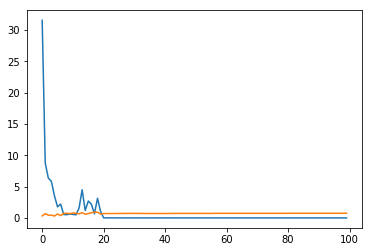

In [6]:

t, x = load_data()
#normalize data
x = (x- np.min(x,axis=0))/(np.max(x,axis=0) - np.min(x,axis=0))
train_x = np.zeros([200,27])
train_x[0:100,:] = x[0:100,:]
train_x[100:, :] = x[200:300, :]
train_y=np.array([0]*200)
train_y[0:100] = t[0:100]
train_y[100:] = t[200:300]
# i,t = shuffle(x,t)
train_x, train_y = shuffle(train_x, train_y)
print(train_x,train_y)

#balance data
# construct d x 2d+1 x 1 MFLL,  d= 27. Hence 3-layer network is 27x55x1
# The activation functions in the hidden layer are logistic function
model = MLFF(weight_initializer='random')

    # o1, o = feedforward(i[1,:],model)
err_tss, sensitivity= GDR_train(train_x,train_y,model, bias=True,alpha=0.6,beta=0.6, momentum=False,max_iter=5000)
epochs = [i for i in range(len(err_tss))]
plt.plot(epochs,err_tss)
plt.plot(epochs, sensitivity)
plt.show()

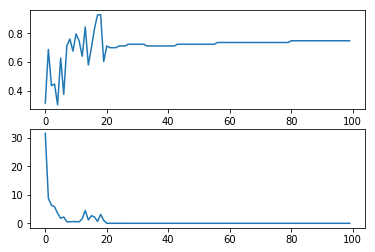

In [10]:
plt.subplot(2,1,1)
plt.plot(epochs, sensitivity)
plt.subplot(2,1,2)
plt.plot(epochs, err_tss)
plt.show()

In [15]:
model2 = MLFF(weight_initializer='random')

# o1, o = feedforward(i[1,:],model)
err_tss, sensitivity= GDR_train(train_x,train_y,model2, bias=True,alpha=0.6,beta=0.6, momentum=True,max_iter=5000)
epochs = [i for i in range(len(err_tss))]
plt.subplot(2,1,1)
plt.plot(epochs, sensitivity)
plt.subplot(2,1,2)
plt.plot(epochs, err_tss)
plt.show()

Error:  43.627929108963286 Sensitivity: 0.012048192771084338
Error:  41.500277010099055 Sensitivity: 0.0
Error:  41.50013084068338 Sensitivity: 0.0
Error:  41.50008530672728 Sensitivity: 0.0
Error:  41.50006316862458 Sensitivity: 0.0
Error:  41.500050101114795 Sensitivity: 0.0
Error:  41.50004148535976 Sensitivity: 0.0
Error:  41.50003538128776 Sensitivity: 0.0
Error:  41.50003083226789 Sensitivity: 0.0
Error:  41.500027312330715 Sensitivity: 0.0
Error:  41.50002450845642 Sensitivity: 0.0
Error:  41.50002222276615 Sensitivity: 0.0
Error:  41.50002032406837 Sensitivity: 0.0
Error:  41.5000187219653 Sensitivity: 0.0
Error:  41.50001735215015 Sensitivity: 0.0
Error:  41.500016167633355 Sensitivity: 0.0
Error:  41.50001513328481 Sensitivity: 0.0
Error:  41.500014222316885 Sensitivity: 0.0
Error:  41.50001341394839 Sensitivity: 0.0
Error:  41.50001269181165 Sensitivity: 0.0
Error:  41.500012042840694 Sensitivity: 0.0
Error:  41.500011456479186 Sensitivity: 0.0
Error:  41.50001092410593 Sens

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class MLFF(object):
    def __init__(self,d1 = 27,weight_initializer = 'random'):
        """
        a 3-layer MLFF network:  d input,  2*d+1 neuron in one hidden layer, 1 output neuron
        """
        d2 = d1 * 2 + 1
        self.d1 = d1
        self.d2 = d2
        # list of activation function
        self.activate = [None]
        # list of activation function derivative
        self.derivative=[None]
        # Layer 1
        # w1: the weights between input layer and hidden layer
        # with shape of d2 rows x d1 columns.
        # Each row of w1 represents the weigths associated with a neuron in hidden layer
        # After adding bias, there are  d2*(d1+1) weights connecting input layer to hidden layer
        if weight_initializer == 'random':
            nums = np.round(np.random.random((d1+1) * d2)-np.random.random((d1+1) * d2), 4)*10
        else:
            nums = [0.0] * ((d1 + 1) * d2)
        self.w1 = np.array(nums).reshape([d2,(d1+1)])
        self.activate.append(self.logistic)
        self.derivative.append(self.derivative_logistic)

        # Layer 2:
        # w2: the weights between hidden layer and output layer
        # there are d2 number of weight , plus one bias. Hence there are d2+1 weights
        if weight_initializer == 'random':
            nums = np.round(np.random.random(d2+1) - np.random.random(d2+1),3)*10
        else:
            nums = [0.0]*(d2+1)
        self.w2 = np.array(nums)
        self.activate.append(self.logistic)
        self.derivative.append(self.derivative_logistic)

        # self.activate_h1 = lambda x:np.ones(self.d1)/(np.ones(self.d1)+ np.exp(-x))


    def logistic(self,net):
        return  np.ones(net.shape) / (np.ones(net.shape) + np.exp(-net))
    def derivative_logistic(self,o):
        return  o * (np.ones(np.shape(o)) - o)


def load_data():
    fp = open('db4_Diff1f_100_128w_AEP2_gp2_ver1-1_ece856.txt','r+')
    lines = fp.readlines()
    input = []
    target = []
    for line in lines:
        line = line.split('\n')[0]

        data=[float(s) for s in line.split(' ') if s!='']
        input.append(data)
        target.append(1)
    fp.close()

    fp = open('db4_Diff1f_100_128w_nonAEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        data=[float(s) for s in line.split(' ') if s != '']
        input.append(data)
        target.append(0)
    fp.close()
    print("shape",np.shape(input),np.shape(target))
    return np.array(target), np.array(input)


def feedforward(i,model,bias = False):
    """

    :param i: an input vector with shape 1x27
    :param model: multi-layer feedforward network model
    :param bias: a flag indicating if bias should be used
    :return:
    o1: intermmediate output from hidden layer
     a scalar output o
    """
    output = 0.0
    input = np.zeros(len(i) + 1)
    input[1:] = i
    if bias:
        input[0] = 1.0


    input = np.transpose(input)
    net_1= np.matmul(model.w1, input)
    # activation of hidden layer
    s1 =model.activate[1](net_1)

    # add feature x0 =1 to intermediate output if bias is enabled
    o1= np.zeros(len(s1)+1)
    o1[1:]= s1
    if bias:
        o1[0] = 1.0

    # output layer
    net_2 = np.dot(o1, model.w2)
    # output of MLFF
    output = model.activate[2](net_2)

    return input, o1, output


def backforward(o0,o1,o2,t):
    """

    :param o1:
    :param o2:
    :param t:
    :param bias:
    :return:
    """
    ## output layer:
    # dE/do = (t-o)
    diff = t-o2
    dE_o2 = -diff
    # do/dnet = o(1-o) for logistic function
    dO_net =model.derivative[2](o2)

    # dnet/w = o1
    # delta = (t-o)*f'(net)= - dE/do * f'(net)
    delta2 = -dE_o2 * dO_net

    # hidden layer :
    # Do not back-propagate bias in hidden layer,  to the last layer
    # model.w2[0,:] is the bias vector between hidden layer and output layer
    dE_o1 = -delta2 * model.w2[1:]
    o1 = o1[1:]
    dO1_net = model.derivative[1](o1)
    delta1 = -dE_o1 * dO1_net

    return delta1,delta2



def predict(inputs,model):
    pred = []
    for i in inputs:
        _,_, o= feedforward(i,model)
        # print('o:',o)
        pred.append(1 if o >= 0.5 else 0)

    return  np.array(pred)


def GDR_train(inputs,targets,model,bias=False,alpha0 = 0.5 , beta0 = 0.5,momentum= False,max_iter= 1000):
    """

    :param inputs:  a set of input vectors, i has shape nxm,  n is the number of sample,  m is the size of one sample
    in this project, each sample has 27 features, hence m=27

    :param targets:   a list of target with shape 1xn
    :param model:   Multi-layer neural network model, containing weights, bias and other parameters. See class MLNN
    :param bias:    a flag indicating if bias should be used
    :param momentum:
    :param alpha:  learning rate
    :param beta: weight of momentum
    :param max_iter:
    :return:
    """
    err_tss= []
    sensitivity = []
    l = len(inputs)
    delta_wn1 = np.zeros(np.shape(model.w1))
    delta_wn2 = np.zeros(np.shape(model.w2))

    for epoch in range(max_iter):
        err =0.0
        # update
        alpha = alpha0*(max_iter-epoch)/max_iter
        beta = beta0*(max_iter-epoch)/max_iter
        # 1 epoch update
        for i in range(l):
            o0, o1, o2 =feedforward(inputs[i,:],model,bias)

            diff =targets[i] - o2
            err += np.square(diff)

            # calculate Etss : Error = 0.5*(o-t)^2
            # GDR update with backforward propagation
            delta1, delta2 = backforward(o0,o1,o2,targets[i])

            # update weights in layer 2
            delta_w2 = alpha * delta2 * o1
            model.w2 += delta_w2
            # update weights in layer 1
            delta_w1 = alpha*np.reshape(delta1,[len(delta1),1])*o0.reshape([1,len(o0)])
            model.w1 += delta_w1

            # when beta ==0, momentum is disabled
            model.w2 += beta * delta_wn2
            model.w1 += beta * delta_wn1
            delta_wn1 = delta_w1
            delta_wn2 = delta_w2

        err= 0.5*err
        if epoch%100 ==0:
            err_tss.append(err)
            # Test sensitivity here
            tot_postive = np.sum(targets)
            pred = predict(inputs, model)
            TP = np.sum(pred[np.where(targets == 1)])
            # print('targets:',targets)
            # print('pred:',pred)
            sens = TP / tot_postive
            sensitivity.append(sens)
            print("Error: ",err,"Sensitivity:",sens)

    return  err_tss,sensitivity



if __name__ == "__main__":
    # load data
    from sklearn.utils import shuffle
    t, x = load_data()
    #normalize data
    x = (x- np.min(x,axis=0))/(np.max(x,axis=0) - np.min(x,axis=0))
    train_x = np.zeros([200,27])
    train_x[0:100,:] = x[0:100,:]
    train_x[100:, :] = x[200:300, :]
    train_y=np.array([0]*200)
    train_y[0:100] = t[0:100]
    train_y[100:] = t[200:300]
    i,t = shuffle(x,t)
    train_x, train_y = shuffle(train_x, train_y)
    print(train_x,train_y)

    #balance data

    # construct d x 2d+1 x 1 MFLL,  d= 27. Hence 3-layer network is 27x55x1
    # The activation functions in the hidden layer are logistic function
    model = MLFF(weight_initializer='random')

    # o1, o = feedforward(i[1,:],model)
    err_tss, sensitivity= GDR_train(i[0:500,:],t[0:500],model, bias=True,alpha0=1,beta0=0, momentum=False,max_iter=5000)
    epochs = [i for i in range(len(err_tss))]
    plt.plot(epochs,err_tss)
    plt.plot(epochs, sensitivity)
    plt.show()
    pass